# A/B Testing Analysis - Landing Page Conversion

This notebook contains the complete statistical analysis of an A/B test run to evaluate a new e-commerce landing page design. We will use a two-sample Z-test and confidence intervals to determine if the observed difference in conversion rates is statistically significant.

**Objective:** Determine if the Treatment (New Page) is better than the Control (Old Page) using a significance level $\alpha = 0.05$.

In [2]:
import pandas as pd

# Load the data
df = pd.read_csv('ab_data.csv')

# --- 1. Identify and Remove Inconsistent Data ---
# Crucial check: 'control' group must see 'old_page', 'treatment' must see 'new_page'.

inconsistent_rows = df[
    ((df['group'] == 'control') & (df['landing_page'] == 'new_page')) |
    ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))
]
print(f"Number of inconsistent rows (page/group mismatch): {len(inconsistent_rows)}")

# Keep only the consistent data
df_cleaned = df[
    ((df['group'] == 'control') & (df['landing_page'] == 'old_page')) |
    ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))
].copy()

# --- 2. Check and Remove User Contamination ---
# Contamination: A user being exposed to BOTH the control and treatment experience.

users_in_both = df_cleaned.groupby('user_id')['group'].nunique()
users_to_drop = users_in_both[users_in_both > 1].index

# Drop contaminated users
df_cleaned = df_cleaned[~df_cleaned['user_id'].isin(users_to_drop)]

print(f"Final cleaned dataset size: {len(df_cleaned)}")

# Save the cleaned data for the next step
df_cleaned.to_csv('ab_data_cleaned.csv', index=False)

Number of inconsistent rows (page/group mismatch): 3893
Final cleaned dataset size: 290587


## 2. Defining Hypotheses and Calculating Metrics

We are testing whether the new page has a statistically significant effect on the conversion rate. We will use a significance level $\alpha = 0.05$.

* **Null Hypothesis ($H_0$):** There is no difference in the conversion rate ($p$) between the new page ($p_{new}$) and the old page ($p_{old}$).
    $$H_0: p_{new} - p_{old} = 0$$

* **Alternative Hypothesis ($H_A$):** There is a statistically significant difference in the conversion rate between the new page and the old page.
    $$H_A: p_{new} - p_{old} \neq 0$$

In [4]:
import pandas as pd

# Load the cleaned data from Step 1
df_cleaned = pd.read_csv('ab_data_cleaned.csv')

# --- 1. Aggregate Data and Calculate Raw Conversion Rates ---
ab_summary = df_cleaned.groupby('group')['converted'].agg(['sum', 'count']).reset_index()
ab_summary.columns = ['group', 'conversions', 'total_users']

# Extract metrics
control_conversions = ab_summary[ab_summary['group'] == 'control']['conversions'].values[0]
control_total = ab_summary[ab_summary['group'] == 'control']['total_users'].values[0]
treatment_conversions = ab_summary[ab_summary['group'] == 'treatment']['conversions'].values[0]
treatment_total = ab_summary[ab_summary['group'] == 'treatment']['total_users'].values[0]

# Calculate Conversion Rates (CR)
control_cr = control_conversions / control_total
treatment_cr = treatment_conversions / treatment_total

print("\n--- Summary Statistics ---")
print(f"Control Conversion Rate (A): {control_cr:.4f}")
print(f"Treatment Conversion Rate (B): {treatment_cr:.4f}")
print(f"Observed Difference (B - A): {(treatment_cr - control_cr):.4f}")

# Save the summary table for the next step
ab_summary.to_csv('ab_test_summary.csv', index=False)


--- Summary Statistics ---
Control Conversion Rate (A): 0.1204
Treatment Conversion Rate (B): 0.1188
Observed Difference (B - A): -0.0016


In [5]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

# Load the summary data from Step 2
ab_summary = pd.read_csv('ab_test_summary.csv')

# --- 1. Extract Data for Z-Test ---
control_conversions = ab_summary[ab_summary['group'] == 'control']['conversions'].values[0]
control_total = ab_summary[ab_summary['group'] == 'control']['total_users'].values[0]
treatment_conversions = ab_summary[ab_summary['group'] == 'treatment']['conversions'].values[0]
treatment_total = ab_summary[ab_summary['group'] == 'treatment']['total_users'].values[0]

# Data arrays for the Z-test function
count = [treatment_conversions, control_conversions] # Successes
nobs = [treatment_total, control_total]             # Observations

# --- 2. Run Two-Sample Z-Test ---
z_stat, p_value = proportions_ztest(count=count, nobs=nobs, alternative='two-sided')

print("\n--- Z-Test Results ---")
print(f"P-value: {p_value:.4f}")

# --- 3. Statistical Conclusion ---
alpha = 0.05
if p_value < alpha:
    print("Conclusion: Reject Null Hypothesis (The difference is statistically significant).")
else:
    print("Conclusion: Fail to Reject Null Hypothesis (The difference is NOT statistically significant).")


--- Z-Test Results ---
P-value: 0.1892
Conclusion: Fail to Reject Null Hypothesis (The difference is NOT statistically significant).



Visualization saved as 'ab_test_confidence_intervals.png'.

Your A/B Test Project is COMPLETE!


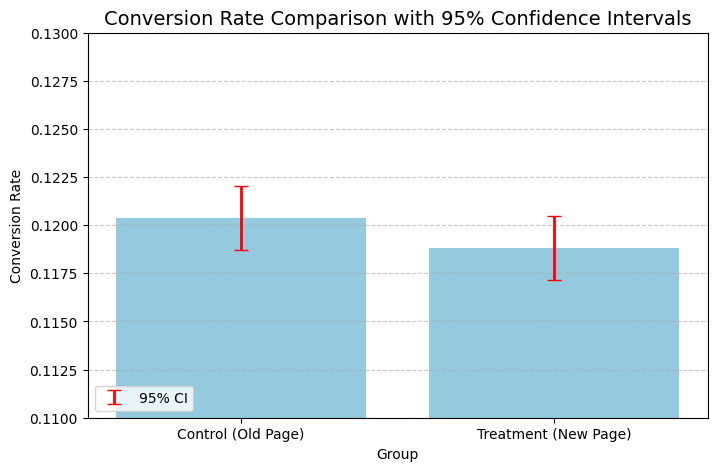

In [6]:
import pandas as pd
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
import seaborn as sns

# Load the summary data
ab_summary = pd.read_csv('ab_test_summary.csv')

# --- 1. Calculate Confidence Intervals (CI) ---
control_conversions = ab_summary[ab_summary['group'] == 'control']['conversions'].values[0]
control_total = ab_summary[ab_summary['group'] == 'control']['total_users'].values[0]
treatment_conversions = ab_summary[ab_summary['group'] == 'treatment']['conversions'].values[0]
treatment_total = ab_summary[ab_summary['group'] == 'treatment']['total_users'].values[0]

# Calculate the 95% Confidence Interval for the conversion rate of each group
ci_control_lower, ci_control_upper = proportion_confint(
    count=control_conversions, nobs=control_total, alpha=0.05, method='normal'
)
ci_treatment_lower, ci_treatment_upper = proportion_confint(
    count=treatment_conversions, nobs=treatment_total, alpha=0.05, method='normal'
)

# Store CIs in a DataFrame for visualization
ci_data = pd.DataFrame({
    'Group': ['Control (Old Page)', 'Treatment (New Page)'],
    'Rate': [control_conversions / control_total, treatment_conversions / treatment_total],
    'Lower_Bound': [ci_control_lower, ci_treatment_lower],
    'Upper_Bound': [ci_control_upper, ci_treatment_upper]
})

# --- 2. Visualization: Confidence Interval Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(x='Group', y='Rate', data=ci_data, color='skyblue')

# Add the error bars representing the 95% CI
y_err = [ci_data['Rate'] - ci_data['Lower_Bound'], ci_data['Upper_Bound'] - ci_data['Rate']]
plt.errorbar(
    x=ci_data['Group'],
    y=ci_data['Rate'],
    yerr=y_err,
    fmt='none',
    capsize=5,
    color='red',
    linewidth=2,
    label='95% CI'
)

# Formatting the plot
plt.title('Conversion Rate Comparison with 95% Confidence Intervals', fontsize=14)
plt.ylabel('Conversion Rate')
plt.ylim(0.11, 0.13)
plt.legend(loc='lower left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot
plt.savefig('ab_test_confidence_intervals.png')
print("\nVisualization saved as 'ab_test_confidence_intervals.png'.")
print("\nYour A/B Test Project is COMPLETE!")

# 🧪 A/B Testing Analysis: Landing Page Conversion Rate

## Project Overview

This project analyzes the results of a high-stakes A/B test conducted on an e-commerce platform. The goal was to determine if a **new landing page design** (`Treatment`) achieved a **statistically significant** change in the conversion rate compared to the existing page (`Control`).

The analysis used Python for data cleaning and **Two-Sample Z-Test** and **Confidence Interval estimation** for statistical rigor, leading to a definitive "Do Not Launch" recommendation.

## 🎯 Executive Summary & Recommendation

**Recommendation:** Do NOT launch the new landing page (Treatment).

### Key Finding
The Treatment Group (New Page) achieved a conversion rate of **$11.88\%$**, which was numerically *worse* than the Control Group's **$12.04\%$**. Crucially, the statistical analysis yielded a **P-value of $0.1892$**.

### Conclusion
Since the P-value ($0.1892$) is much greater than the standard significance level ($\alpha = 0.05$), we **Fail to Reject the Null Hypothesis ($H_0$)**. We cannot conclude that the New Page is genuinely different from the Old Page. The observed difference is likely due to random chance, not the design itself.

---

## Methodology and Technical Workflow

### 1. Hypothesis Definition (Two-Tailed Test)

* **Null Hypothesis ($H_0$):** There is no difference in conversion rates. $H_0: p_{new} - p_{old} = 0$
* **Alternative Hypothesis ($H_A$):** There is a statistically significant difference. $H_A: p_{new} - p_{old} \neq 0$

### 2. Data Cleaning

* **Initial Data:** $294,480$ observations.
* **Cleaning Steps:** Removed $3,893$ inconsistent rows (where group assignment didn't match the page viewed).
* **Contamination:** Confirmed 0 users saw both the Control and Treatment groups.
* **Final Sample Size:** $290,587$ users used for analysis.

### 3. Statistical Results

| Group | Total Users | Conversions | Conversion Rate (CR) | 95% CI Range |
| :--- | :--- | :--- | :--- | :--- |
| **Control (Old Page)** | 145,274 | 17,489 | **$12.04\%$** | $[11.87\%, 12.21\%]$ |
| **Treatment (New Page)** | 145,313 | 17,264 | **$11.88\%$** | $[11.71\%, 12.05\%]$ |
| **P-value** | \- | \- | \- | **$0.1892$** |

### 4. Confidence Interval Visualization

The visualization below confirms that the $95\%$ Confidence Intervals for both groups overlap significantly. This visual proof reinforces the P-value finding: the true conversion rates of the new and old pages are likely within the same range, and thus, the new page does not offer a reliable lift.

![A/B Test Confidence Interval Plot](ab_test_confidence_intervals.png)

---

### **View the Full Analysis**

The complete Python code, data cleaning steps, statistical calculations, and raw data outputs are available in the linked Jupyter Notebook:

➡️ **[ab\_test\_analysis.ipynb](ab_test_analysis.ipynb)**